In [1]:
using LinearAlgebra
using Statistics
using IterativeSolvers
using Convex
using SCS
using COSMO
using NLsolve
using DifferentialEquations
using SparseArrays

using JLD2

using LightGraphs
using PyPlot
PyPlot.svg(true);

In [2]:
N = 12

g = LightGraphs.grid([1, N], periodic=true)
# g = LightGraphs.erdos_renyi(N^2, 0.35)
E = incidence_matrix(g; oriented=true)

# coupling constants
K = 2.0 # coupling scale
B = (K/mean(LightGraphs.degree(g)))*ones(ne(g));

# laplacian
L = Symmetric(E*diagm(0=>B)*E')

# u, Q = eigen(L)

L_sp = dropzeros(sparse(L))

# balanced power flows/natural frequencies
ω = randn(nv(g))
ω .-= mean(ω)
ω = ω./std(ω);

In [3]:
function f_steady_state(F, δ)
    F .= ω/nv(g) - E*(B.*sin.(E'*δ))
end

# initial condition
δ0 = 1e-2randn(nv(g))

sln = nlsolve(f_steady_state, δ0; autodiff=:forward)

@show converged(sln);

# order parameter at the fixed point
R0 = abs2(mean(exp.(1im*sln.zero)))

@show R0;

converged(sln) = true
R0 = 0.9919772771230794


In [4]:
# check by solving ODE
function f_kuramoto(du, u, p, t)
    f_steady_state(du, u)
end

f_kuramoto (generic function with 1 method)

In [5]:
# Noisy extension
δbar = sln.zero

# construct S matrix
h = complete_graph(nv(g))
Eh = incidence_matrix(h; oriented=true)
cosδbar = cos.(Eh'*δbar)
# cosδbar = ones(ne(h))

# Laplacian of the corresponding complete graph
S = Symmetric(-Eh*diagm(0=>cosδbar)*Eh'/nv(g)^2)

# weighted Laplacian expanded around fixed point
B_fp = cos.(E'*δbar).*B
L_fp = Symmetric(E*diagm(0 => B_fp)*E')

12×12 Symmetric{Float64, Matrix{Float64}}:
  1.99931   -0.999834   0.0       …   0.0        0.0       -0.99948
 -0.999834   1.99866   -0.99883       0.0        0.0        0.0
  0.0       -0.99883    1.99876       0.0        0.0        0.0
  0.0        0.0       -0.999931      0.0        0.0        0.0
  0.0        0.0        0.0           0.0        0.0        0.0
  0.0        0.0        0.0       …   0.0        0.0        0.0
  0.0        0.0        0.0           0.0        0.0        0.0
  0.0        0.0        0.0           0.0        0.0        0.0
  0.0        0.0        0.0          -0.998962   0.0        0.0
  0.0        0.0        0.0           1.99847   -0.999511   0.0
  0.0        0.0        0.0       …  -0.999511   1.99928   -0.999768
 -0.99948    0.0        0.0           0.0       -0.999768   1.99925

In [6]:
# Eq = Convex.Variable(nv(g), nv(g))
# C = Convex.Variable(nv(g), nv(g))
Eq = Convex.Semidefinite(nv(g))
C = Convex.Semidefinite(nv(g))

# D = spdiagm(0 => u)
# St = Q'*S*Q

problem = maximize(tr(S*Eq), [
        L_fp*Eq + Eq*L_fp == C, 
        Eq*ones(N) == zeros(N),
#         sum(Eq) == 0.0,
        diag(C, 0) == 1.0,
#         tr(C) == nv(g),
        ])

maximize
└─ sum (affine; real)
   └─ diag (affine; real)
      └─ * (affine; real)
         ├─ …
         └─ …
subject to
├─ == constraint (affine)
│  ├─ + (affine; real)
│  │  ├─ * (affine; real)
│  │  │  ├─ …
│  │  │  └─ …
│  │  └─ * (affine; real)
│  │     ├─ …
│  │     └─ …
│  └─ 12×12 real variable (id: 793…293)
├─ == constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ 12×12 real variable (id: 143…108)
│  │  └─ 12-element Vector{Float64}
│  └─ 12-element Vector{Float64}
└─ == constraint (affine)
   ├─ diag (affine; real)
   │  └─ 12×12 real variable (id: 793…293)
   └─ 1.0

status: `solve!` not called yet

In [7]:
# Convex.solve!(problem, () -> SCS.Optimizer(verbose=true, max_iters=20000))
Convex.solve!(problem, () -> COSMO.Optimizer(verbose=true, 
        eps_abs=1e-7, eps_rel=1e-7, max_iter=150000))

------------------------------------------------------------------
          COSMO v0.8.1 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2021
------------------------------------------------------------------

Problem:  x ∈ R^{289},
          constraints: A ∈ R^{457x289} (1585 nnz),
          matrix size to factor: 746x746,
          Floating-point precision: Float64
Sets:     ZeroSet) of dim: 301
          DensePsdConeTriangle) of dim: 78
          DensePsdConeTriangle) of dim: 78
Settings: ϵ_abs = 1.0e-07, ϵ_rel = 1.0e-07,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 150000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol

In [8]:
@show sum(C.value)
@show sum(Eq.value)
@show sum(S)

# C_constr = C.value
# E_constr = Eq.value

sum(C.value) = 6.219325054956926e-10
sum(Eq.value) = -1.4113432644791146e-12
sum(S) = -1.3877787807814457e-17


-1.3877787807814457e-17

In [9]:
Cs = C.value
Eqs = Eq.value

12×12 Matrix{Float64}:
  0.125032  -0.125067   0.125024  …  -0.125032   0.125039  -0.125041
 -0.125067   0.125103  -0.12506       0.125068  -0.125075   0.125076
  0.125024  -0.12506    0.125017     -0.125025   0.125031  -0.125033
 -0.125224   0.12526   -0.125216      0.125224  -0.125231   0.125233
  0.12524   -0.125276   0.125232     -0.125241   0.125248  -0.125249
 -0.124925   0.124961  -0.124918  …   0.124926  -0.124932   0.124934
  0.125343  -0.125379   0.125336     -0.125344   0.125351  -0.125352
 -0.125664   0.125701  -0.125656      0.125665  -0.125672   0.125674
  0.125276  -0.125311   0.125268     -0.125276   0.125283  -0.125285
 -0.125032   0.125068  -0.125025      0.125033  -0.12504    0.125041
  0.125039  -0.125075   0.125031  …  -0.12504    0.125046  -0.125048
 -0.125041   0.125076  -0.125033      0.125041  -0.125048   0.12505

In [12]:
eigen(Eq.value)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
14-element Vector{Float64}:
 -5.476838972650524e-8
 -4.611278327869161e-9
 -3.396328405321322e-9
 -2.5935657202325516e-9
 -2.6553394847952895e-10
  6.6528084971156015e-15
  4.577832964748559e-10
  4.282382487572191e-9
  6.526777548232906e-9
  1.006345137169135e-8
  1.3738166866538667e-7
  8.374531237689905e-7
  6.98459512929156e-6
  1.7535245707892788
vectors:
14×14 Matrix{Float64}:
 -0.0747255   0.0374749    0.257937   …  -0.476854   -0.361601     0.267103
 -0.0281111   0.260845     0.182721      -0.129957   -0.374939    -0.267624
  0.358462    0.0307915   -0.0506642     -0.297798   -0.0418346    0.267366
  0.388518   -0.62925     -0.355147      -0.0417036   0.00367918  -0.267214
  0.279083   -0.0133442    0.110993       0.20159    -0.0720719    0.267088
  0.190546    0.637723    -0.407679   …  -0.104609    0.126748    -0.267055
 -0.174405   -0.0529835   -0.0979117      0.158727    0.0133138    0.267196
 -0.148758   -0.

In [13]:
Eq.value*ones(N)

14-element Vector{Float64}:
  2.295552636866205e-12
 -2.746275429288403e-12
  2.877392768496634e-12
 -2.6700308630722702e-12
  2.728456349743169e-12
 -2.724709347035059e-12
  2.899153139779287e-12
 -3.154060346233223e-12
  3.0409841311751507e-12
 -2.8703706078658797e-12
  2.8017310693684294e-12
 -3.1362690222636047e-12
  3.203493026404658e-12
 -2.4487079031132453e-12

In [14]:
# optimal solution
problem.optval

-0.12422614526775531

In [15]:
# compare to uniform noise
C_unif = (I*(1 + 1/(nv(g)-1)) - ones(nv(g), nv(g))/(nv(g) - 1))

E_uf = lyap(Array(L), -C_unif)

optval_uniform = tr(E_uf*S)

@show optval_uniform
@show optval_uniform/problem.optval

LoadError: LAPACKException(1)

In [16]:
# project on subspace 1^⟂
u, V = eigen(Array(L))

V0 = V[2:end,:]
L0 = V0*L*V0'
C0 = V0*C_unif*V0'
S0 = V0*S*V0'

E_uf = lyap(L0, -C0)

optval_uniform = tr(E_uf*S0)

@show optval_uniform
@show optval_uniform/problem.optval

optval_uniform = -0.5166479522111438
optval_uniform / problem.optval = 4.158930884457277


4.158930884457277

In [17]:
Copt = C.value
Eopt = Eq.value
optval = problem.optval

R0
# jldsave("data/periodic_line_$(N)_fix_Cii_K_$(K).jld2"; g, K, B, δ0, sln, δbar, R0, Copt, Eopt, optval, optval_uniform)

0.9918512288183655

In [94]:
@show eigvals(Symmetric(C.value))
@show eigvals(Symmetric(Eq.value));

eigvals(Symmetric(C.value)) = [-6.322048266998557e-7, -1.8016870069220413e-8, -8.836899456778539e-9, -2.921568941221162e-9, -1.9596143203377875e-11, 2.0315596093792676e-9, 3.767041087757182e-9, 9.305926352396193e-9, 1.5143801660893901e-7, 10.00000049546679]
eigvals(Symmetric(Eq.value)) = [-2.4699571142175406e-9, -1.099404275829239e-9, 2.683761134247099e-13, 1.3457477725976455e-12, 9.188824954746252e-10, 2.4507262727488788e-9, 3.778250998144545e-9, 5.590413868955454e-7, 4.710784378732661e-6, 1.2531836220299488]


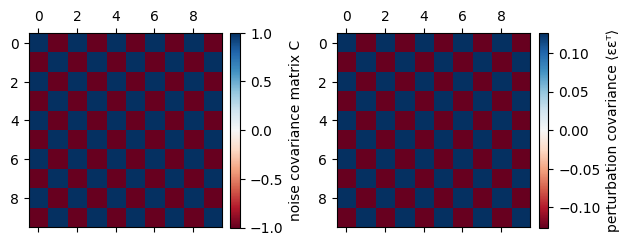

In [95]:
fig, axs = subplots(1, 2)

ax = axs[1]
cmin, cmax = abs(minimum(C.value)), abs(maximum(C.value))
cm = maximum([cmin, cmax])
sc = ax.matshow(C.value, cmap="RdBu", vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="noise covariance matrix C")

ax = axs[2]
cmin, cmax = abs(minimum(Eq.value)), abs(maximum(Eq.value))
cm = maximum([cmin, cmax])
sc = ax.matshow(Eq.value, cmap="RdBu", vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="perturbation covariance ⟨εεᵀ⟩")

fig.tight_layout()

In [18]:
# find a particular realization of the noise input
function G_from_C(C)
    U, Σ, V = svd(C)
    U*diagm(0 => sqrt.(Σ))*U'
end

G = G_from_C(C.value)
η = G*randn(nv(g));

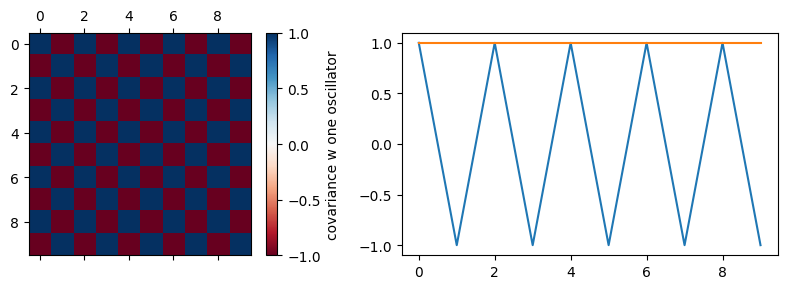

In [97]:
# visualization for grid graphs

fig, axs = subplots(1, 2, figsize=(9, 3))

ax = axs[1]
# sc = ax.matshow(reshape(η, N, N)', cmap="RdBu")
# fig.colorbar(sc, ax=ax, label="noise strength η(t)", fraction=0.046, pad=0.04)

sc = ax.matshow(reshape(C.value, N, N)', cmap="RdBu")
fig.colorbar(sc, ax=ax, label="covariance w one oscillator", fraction=0.046, pad=0.04)

ax = axs[2]
ax.plot(C.value[1,:])
ax.plot(abs.(C.value[1,:]))

fig.tight_layout()

In [67]:
# run a SDE solution to check results

function solve_sde(σ, δ0, G; tspan=(0.0, 3000.0), dt=0.01)
    # σ is the noise strength (multiplies the noise matrix)
    function g_kuramoto(du, u, p, t)
        du .= 1/sqrt(2)*σ*G
    end
    
    prob = SDEProblem(f_kuramoto, g_kuramoto, δ0, tspan; noise_rate_prototype=zeros(size(G)...))
    sdesln = solve(prob, EM(), dt=dt)
end

function solve_sde_v2(σ, δ0, G; tspan=(0.0, 3000.0), dt=0.01, saveat=nothing)
    function Rsqr_from_u(u)
        abs(mean(exp.(1im*u)))^2
    end
    
    function Rsqr_grad(u)
        # gradient of R^2
        n = length(u)
        J = zeros(n)
        
        # can we make this nicer?
        for i=1:n
            J[i] = 2/n^2 * sum(sin.(u .- u[i]))
        end
        
        J
    end
    
    # solve kuramoto model *and* automatically get time average of the order parameter
    function f_kuramoto(du, u, p, t)
        dδ = @view du[1:end-1]
        f_steady_state(dδ, u[1:end-1])
        
        # time average y(t) = 1/t\int_0^t R^2(t) dt of the order parameter satisfies
        # dy/dt = -y/t + R^2(t)/t
        
        if t > 0
            # solve ode
            y = u[end]
            Rsqr = Rsqr_from_u(u[1:end-1])
            
            du[end] = -y/t + Rsqr/t
        else
            # use formula for y'(0) = 1/2 (R^2)'(0) = 1/2 grad(R^2)(0)'*du(0)
            J = Rsqr_grad(u[1:end-1])
            du[end] = 0.5J'*du[1:end-1]
        end
    end
    
    # σ is the noise strength (multiplies the noise matrix)
    function g_kuramoto(du, u, p, t)
        du[1:end-1,:] .= 1/sqrt(2)*σ*G
        
        # no noise on the time average
        du[end,:] .= 0.0
    end
    
    n, m = size(G)
    
    Rsqr0 = Rsqr_from_u(δ0)
    u0 = vcat(δ0, [Rsqr0])
    prob = SDEProblem(f_kuramoto, g_kuramoto, u0, tspan; noise_rate_prototype=zeros(n+1, m))
    sdesln = solve(prob, EM(), dt=dt, saveat=saveat)
end

function cumtrapz_avg(t::T, Y::T) where {T <: AbstractVector}
    # Estimates the cumulative time average integral 1/T ∫₀ᵀ f(t) dt using the trapezoid rule
    # where time points are in t and corresponding samples of f are in Y
    
    # Check matching vector length
    @assert length(t) == length(Y)
    
    # Initialize Output
    out = similar(t)
    out[1] = 0.0
    # Iterate over arrays
    for i in 2:length(t)
        out[i] = out[i-1] + 0.5*(t[i] - t[i-1])*(Y[i] + Y[i-1])
    end
    out[2:end] ./= (t[2:end] .- t[1])
    out[1] = out[2]

    out
end

function Rsqr_from_sde(sdesln)
    # numerically integrate and average
    Rsqrs = [abs(mean(exp.(1im*u)))^2 for u in sdesln.u]
end

Rsqr_from_sde (generic function with 1 method)

In [105]:
# v1, r^2 by hand
σ = 0.5
G = G_from_C(C.value)

sdesln = solve_sde(σ, sln.zero, G; tspan=(0.0, 10000.0))
Rsqrs_sde = Rsqr_from_sde(sdesln);
Rsqrs_avg = cumtrapz_avg(sdesln.t, Rsqrs_sde);

In [106]:
# v2, r^2 from differential equation
σ = 0.5
G = G_from_C(C.value)

sdesln_v2 = solve_sde_v2(σ, sln.zero, G; tspan=(0.0, 10000.0))

# works!
Rsqrs_v2 = [abs(mean(exp.(1im*u[1:end-1])))^2 for u in sdesln_v2.u]
Rsqrs_avg_v2_old = cumtrapz_avg(sdesln_v2.t, Rsqrs_v2);
Rsqrs_avg_v2 = vcat([u[end] for u in sdesln_v2.u]...);



In [22]:
G_unif = G_from_C(C_unif)

sdesln_unif = solve_sde(σ, sln.zero, G_unif; tspan=(0.0, 10000.0))
Rsqrs_sde_unif = Rsqr_from_sde(sdesln_unif);
Rsqrs_avg_unif = cumtrapz_avg(sdesln_unif.t, Rsqrs_sde_unif);

In [23]:
ts = sdesln.t
ts_unif = sdesln_unif.t

# jldsave("data/periodic_line_$(N)_fix_Cii_K_$(K)_sigma_$(σ)_timeseries.jld2"; Rsqrs_avg, Rsqrs_avg_unif, ts, ts_unif, σ, G)

1000001-element Vector{Float64}:
     0.0
     0.01
     0.02
     0.03
     0.04
     0.05
     0.060000000000000005
     0.07
     0.08
     0.09
     0.09999999999999999
     0.10999999999999999
     0.11999999999999998
     ⋮
  9999.890000171854
  9999.900000171854
  9999.910000171854
  9999.920000171855
  9999.930000171855
  9999.940000171855
  9999.950000171855
  9999.960000171855
  9999.970000171856
  9999.980000171856
  9999.990000171856
 10000.0

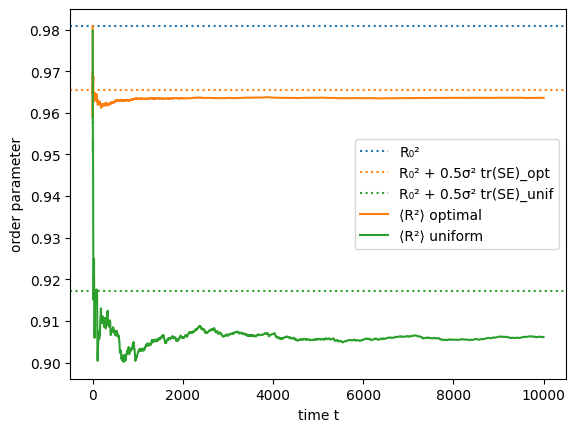

PyObject Text(24.000000000000007, 0.5, 'order parameter')

In [24]:
fig, ax = subplots()
ax.axhline(R0, ls=":", label="R₀²")
ax.axhline(R0 + 0.5σ^2*problem.optval, label="R₀² + 0.5σ² tr(SE)_opt", color="C1", ls=":")
ax.axhline(R0 + 0.5σ^2*optval_uniform, label="R₀² + 0.5σ² tr(SE)_unif", color="C2", ls=":")
# ax.axhline(R0 - σ^2*problem.optval)

# ax.set_ylim(R0 - 5σ^2*abs(optval_uniform), R0 + 5σ^2*abs(optval_uniform))

# ax.plot(Rsqrs_sde, alpha=0.5)
ax.plot(sdesln.t, Rsqrs_avg, color="C1", label="⟨R²⟩ optimal")
ax.plot(sdesln_unif.t, Rsqrs_avg_unif, color="C2", label="⟨R²⟩ uniform")

# ax.set_xlim(150000, 200000)

ax.legend()
ax.set_xlabel("time t")
ax.set_ylabel("order parameter")

In [98]:
function noise_compare(σ_max, n)
    Rsqrs_opt = []
    Rsqrs_uni = []
    σs = LinRange(0.0, σ_max, n)
    
    for σ in σs
        @show σ
        sdesln_v2 = solve_sde_v2(σ, sln.zero, G; tspan=(0.0, 100000.0), saveat=[100000.0])
#         sdesln = solve_sde(σ, sln.zero, G; tspan=(0.0, 15000.0), dt=0.01)
#         Rsqrs_sde = Rsqr_from_sde(sdesln);
#         Rsqrs_avg = cumtrapz_avg(sdesln.t, Rsqrs_sde);
        
        push!(Rsqrs_opt, sdesln_v2.u[end][end])
        
        sdesln_v2 = solve_sde_v2(σ, sln.zero, G_unif; tspan=(0.0, 100000.0), saveat=[100000.0])
#         sdesln_unif = solve_sde(σ, sln.zero, G_unif; tspan=(0.0, 15000.0), dt=0.01)
#         Rsqrs_sde_unif = Rsqr_from_sde(sdesln_unif);
#         Rsqrs_avg_unif = cumtrapz_avg(sdesln_unif.t, Rsqrs_sde_unif);        
        
        push!(Rsqrs_uni, sdesln_v2.u[end][end])
    end
    
    σs, Rsqrs_opt, Rsqrs_uni
end

noise_compare (generic function with 1 method)

In [99]:
G = G_from_C(C.value)
G_unif = G_from_C(C_unif)

σs, Rsqrs_opt, Rsqrs_uni = noise_compare(3.0, 51)

σ = 0.0
σ = 0.06
σ = 0.12
σ = 0.18
σ = 0.24
σ = 0.30000000000000004
σ = 0.36
σ = 0.42000000000000004
σ = 0.48
σ = 0.54
σ = 0.6000000000000001
σ = 0.66
σ = 0.72
σ = 0.78
σ = 0.8400000000000001
σ = 0.8999999999999999
σ = 0.96
σ = 1.02
σ = 1.08
σ = 1.1400000000000001
σ = 1.2000000000000002
σ = 1.26
σ = 1.32
σ = 1.3800000000000001
σ = 1.44
σ = 1.5
σ = 1.56
σ = 1.62
σ = 1.6800000000000002
σ = 1.7399999999999998
σ = 1.7999999999999998
σ = 1.8599999999999999
σ = 1.92
σ = 1.98
σ = 2.04
σ = 2.0999999999999996
σ = 2.16
σ = 2.2199999999999998
σ = 2.2800000000000002
σ = 2.34
σ = 2.4000000000000004
σ = 2.46
σ = 2.52
σ = 2.58
σ = 2.64
σ = 2.7
σ = 2.7600000000000002
σ = 2.82
σ = 2.88
σ = 2.94
σ = 3.0


(range(0.0, stop=3.0, length=51), Any[0.9934687759800052, 0.9932339194840546, 0.9925279438069721, 0.991348501881236, 0.989703185472589, 0.9875766111775361, 0.9849250920314627, 0.9818296458093313, 0.9781996026616399, 0.9740550725301204  …  0.45819845511567914, 0.44729235180051263, 0.4358955727008122, 0.4255015185039599, 0.41463438092699967, 0.397870972412155, 0.39298440728572664, 0.37881100425938546, 0.3658288708628024, 0.36144713666925327], Any[0.9934687759800052, 0.9926170244219151, 0.990170963774504, 0.9860280735118887, 0.9801998513270597, 0.9727140714726827, 0.9636292531226185, 0.9527236405675367, 0.9406616218057954, 0.9257294744298777  …  0.17788306324652406, 0.17260336658498837, 0.16909228397184184, 0.16606291669706108, 0.1611648660177496, 0.1580074254023998, 0.15490643733769094, 0.152059732691423, 0.1497802627956518, 0.14656620102513684])

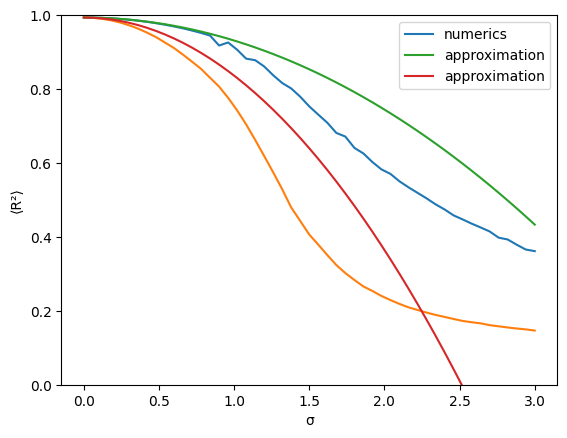

PyObject Text(24.000000000000007, 0.5, '⟨R²⟩')

In [100]:
fig, ax = subplots()

ax.plot(σs, Rsqrs_opt, label="numerics")
ax.plot(σs, Rsqrs_uni)
ax.plot(σs, map(σ ->  R0 + 0.5σ^2*problem.optval, σs), label="approximation")
ax.plot(σs, map(σ ->  R0 + 0.5σ^2*optval_uniform, σs), label="approximation")

ax.set_ylim(0, 1)

ax.legend()
ax.set_xlabel("σ")
ax.set_ylabel("⟨R²⟩")

In [75]:
jldsave("data/periodic_line_$(N)_fix_Cii_K_$(K)_sigma_series.jld2"; R0, σs, Rsqrs_opt, Rsqrs_uni, optval, optval_uniform)